In [1]:
from pathlib import Path
import sys

BASE_PATH = Path('../')
PATH_TO_DATA = BASE_PATH/'data'
PATH_TO_MODELS = BASE_PATH/'checkpoints'

PATH_TO_DATA.mkdir(exist_ok=True, parents=True)
PATH_TO_MODELS.mkdir(exist_ok=True, parents=True)

sys.path.append(str(BASE_PATH/'..'))

#### <b>Load Libraries</b>

In [2]:
import time
import random
from pathlib import Path

from PIL import Image

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import models
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from utils import progress_bar

stty: 'standard input': Inappropriate ioctl for device


#### <b>Notebook Constants</b>

In [3]:
RANDOM_STATE = 42
BATCH_SIZE = 64
NUM_WORKERS = 8
DEVICE = 'cuda'

In [4]:
def set_random_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

#### <b>Define Custom Dataset</b>

In [5]:
class CustomDataset(Dataset):
    def __init__(self, manifest, image_directory, train_mode):

        if train_mode:
            self.transform = transforms.Compose([
                transforms.Resize(128),
                transforms.RandomHorizontalFlip(),
                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor()
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(128),
                transforms.ToTensor()
            ])

        image_directory = Path(image_directory)
        age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }
        
        self.filenames = [image_directory/x for x in manifest['image_path']]
        self.labels = [age_class_to_label[x] for x in manifest['age_class']]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img = self.transform(Image.open(self.filenames[idx]))
        label = self.labels[idx]

        return img, label

#### <b>Training utils</b>

In [6]:
def train(model, dataloader, criterion, optimizer):
    
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):

        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(dataloader), f'Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100*correct/total:.2f}%%%')  

    return train_loss/(batch_idx+1), 100.*correct/total

def test(model, dataloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(dataloader), f'Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100*correct/total:.2f}%%%')  
    
    return test_loss/(batch_idx+1), 100.*correct/total


def adjust_learning_rate(learning_rate, optimizer, epoch):
    lr = learning_rate
    if epoch >= 10:
        lr /= 10
    if epoch >= 20:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train_model(manifest_filename, checkpoint_name):

    set_random_seed(RANDOM_STATE)
    
    train_manifest = pd.read_csv(PATH_TO_DATA/manifest_filename)
    train_dataset = CustomDataset(train_manifest, PATH_TO_DATA/'images', train_mode=True)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    test_manifest = pd.read_csv(PATH_TO_DATA/'test_manifest.csv')
    test_dataset = CustomDataset(test_manifest, PATH_TO_DATA/'images', train_mode=False)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

    learning_rate = 0.01
    max_epoch = 30

    model = models.resnet18(weights=None)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 8)
    model = model.to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    list_train_loss, list_train_acc = [], []
    list_loss, list_acc = [], []
    for epoch in range(max_epoch):
        
        print(f'\nEpoch: {epoch}')

        train_loss, train_acc = train(model, train_dataloader, criterion, optimizer)
        val_loss, val_acc = test(model, test_dataloader, criterion)
        
        adjust_learning_rate(learning_rate, optimizer, epoch)
        
        list_train_loss.append(train_loss)
        list_train_acc.append(train_acc)
        list_loss.append(val_loss)
        list_acc.append(val_acc)
    
    # save checkpoint
    path_to_checkpoint = PATH_TO_MODELS/checkpoint_name
    path_to_checkpoint.mkdir(exist_ok=True, parents=True)
    torch.save(model.state_dict(), path_to_checkpoint/'state_dict.pth')

    return np.array(list_train_loss), np.array(list_train_acc), np.array(list_loss), np.array(list_acc)

#### <b>Train the "Original Model"</b>

* Train the Original model to serve as the base model for performing Machine Unlearning

In [7]:
train_loss, train_acc, test_loss, test_acc = train_model(manifest_filename='train_manifest.csv', checkpoint_name='origin')


Epoch: 0
 [=======================================>]  Step: 84ms | Tot: 1s702ms | Loss: 1.973 | Acc: 22.89% 81/81 
 [======================================>.]  Step: 46ms | Tot: 227ms | Loss: 1.928 | Acc: 25.69% 21/21 

Epoch: 1
 [=======================================>]  Step: 15ms | Tot: 1s494ms | Loss: 1.833 | Acc: 30.14% 81/81 
 [======================================>.]  Step: 7ms | Tot: 231ms | Loss: 2.071 | Acc: 27.39% 21/21  

Epoch: 2
 [=======================================>]  Step: 9ms | Tot: 1s483ms | Loss: 1.615 | Acc: 37.23% 81/81  
 [======================================>.]  Step: 10ms | Tot: 196ms | Loss: 1.616 | Acc: 36.19% 21/21 

Epoch: 3
 [=======================================>]  Step: 12ms | Tot: 1s632ms | Loss: 1.468 | Acc: 41.45% 81/81 =====>................................]  Step: 26ms | Tot: 347ms | Loss: 1.507 | Acc: 39.43% 17/81 
 [======================================>.]  Step: 10ms | Tot: 230ms | Loss: 1.477 | Acc: 40.51% 21/21 

Epoch: 4
 [=========

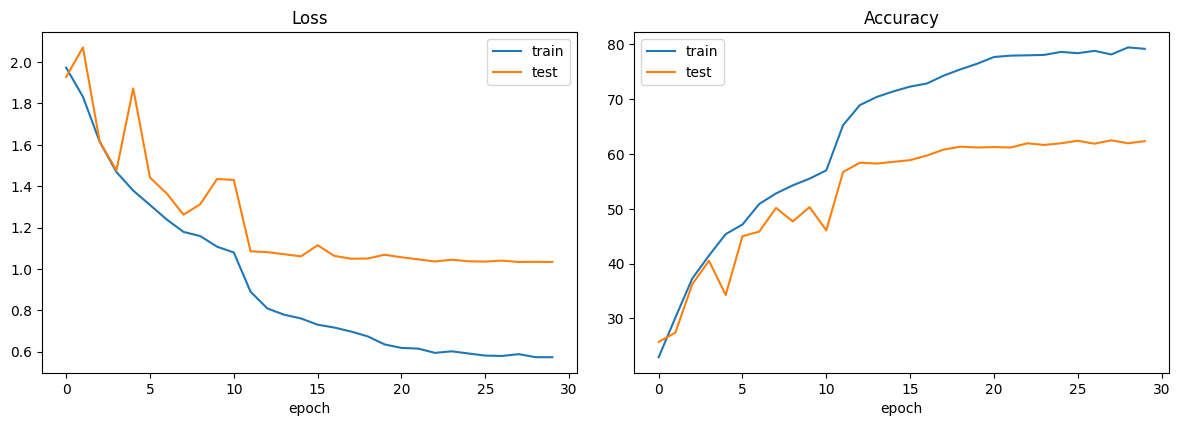

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()

axs[0].set_title('Loss')
axs[0].set_xlabel('epoch')
axs[0].plot(train_loss, label='train')
axs[0].plot(test_loss, label='test')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].set_xlabel('epoch')
axs[1].plot(train_acc, label='train')
axs[1].plot(test_acc, label='test')
axs[1].legend()

#### <b> Train the "Retrained Model"</b>
* A model trained on only the retain dataset from scratch, excluding the forget dataset.
* This model can serve as a proxy ground-truth for calculating the potential ground-truth (1) model utility and (2) forgetting score.

In [9]:
train_loss, train_acc, test_loss, test_acc = train_model(manifest_filename='retain_manifest.csv', checkpoint_name='retrained')


Epoch: 0
 [=======================================>]  Step: 74ms | Tot: 1s312ms | Loss: 1.982 | Acc: 23.24% 77/77 
 [======================================>.]  Step: 10ms | Tot: 240ms | Loss: 2.335 | Acc: 19.06% 21/21 

Epoch: 1
 [=======================================>]  Step: 13ms | Tot: 1s560ms | Loss: 1.787 | Acc: 30.91% 77/77 
 [======================================>.]  Step: 9ms | Tot: 186ms | Loss: 1.897 | Acc: 28.47% 21/21  

Epoch: 2
 [=======================================>]  Step: 14ms | Tot: 1s387ms | Loss: 1.622 | Acc: 38.54% 77/77 
 [======================================>.]  Step: 7ms | Tot: 260ms | Loss: 1.798 | Acc: 29.86% 21/21  

Epoch: 3
 [=======================================>]  Step: 8ms | Tot: 1s424ms | Loss: 1.476 | Acc: 42.76% 77/77  
 [======================================>.]  Step: 7ms | Tot: 185ms | Loss: 2.880 | Acc: 26.23% 21/21  

Epoch: 4
 [=======================================>]  Step: 14ms | Tot: 1s540ms | Loss: 1.390 | Acc: 45.12% 77/77 
 [==

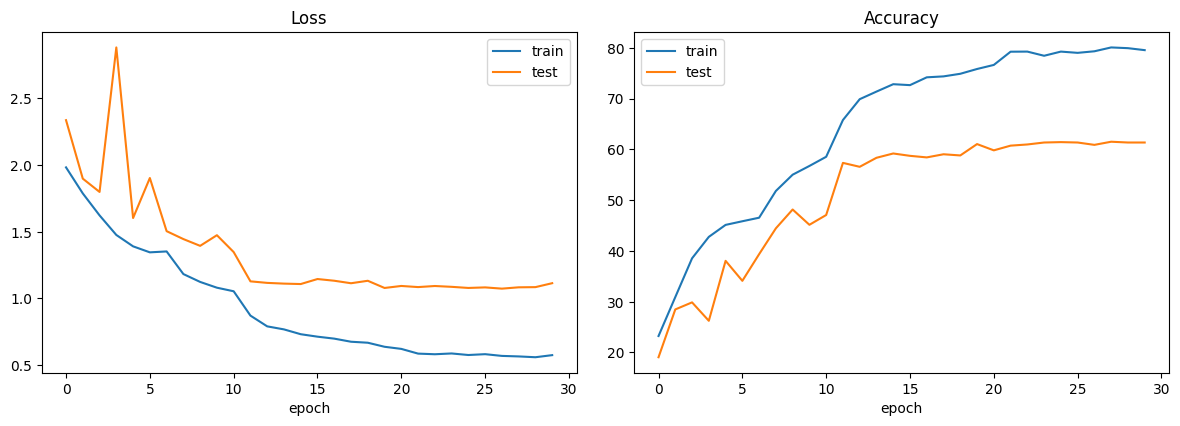

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()

axs[0].set_title('Loss')
axs[0].set_xlabel('epoch')
axs[0].plot(train_loss, label='train')
axs[0].plot(test_loss, label='test')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].set_xlabel('epoch')
axs[1].plot(train_acc, label='train')
axs[1].plot(test_acc, label='test')
axs[1].legend()

#### <b> Train the "Shadow Models"</b>
* The models which will be used for MIA

In [11]:
for shadow_idx in range(128):
    train_model(manifest_filename=f'shadow_manifests/{shadow_idx:04}.csv', checkpoint_name=f'shadow/{shadow_idx:04}')


Epoch: 0
 [=======================================>]  Step: 15ms | Tot: 1s652ms | Loss: 1.978 | Acc: 22.73% 82/82 
 [======================================>.]  Step: 6ms | Tot: 220ms | Loss: 2.100 | Acc: 21.53% 21/21  

Epoch: 1
 [=======================================>]  Step: 15ms | Tot: 1s375ms | Loss: 1.863 | Acc: 29.40% 82/82 
 [======================================>.]  Step: 10ms | Tot: 239ms | Loss: 2.494 | Acc: 16.44% 21/21 

Epoch: 2
 [=======================================>]  Step: 15ms | Tot: 1s651ms | Loss: 1.662 | Acc: 35.39% 82/82 
 [======================================>.]  Step: 8ms | Tot: 183ms | Loss: 1.774 | Acc: 34.10% 21/21  

Epoch: 3
 [=======================================>]  Step: 13ms | Tot: 1s562ms | Loss: 1.465 | Acc: 41.04% 82/82 
 [======================================>.]  Step: 10ms | Tot: 219ms | Loss: 1.978 | Acc: 25.00% 21/21 

Epoch: 4
 [=======================================>]  Step: 9ms | Tot: 1s464ms | Loss: 1.389 | Acc: 44.89% 82/82  
 [==